In [1]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, f1_score, roc_auc_score, accuracy_score, recall_score, precision_score, mean_squared_error
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, CatBoostRegressor
import copy
import os
import matplotlib.pyplot as plt
%matplotlib inline  
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings("ignore")
RS = 42

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
DATA_DIR = 'drive/MyDrive/interfax'

# 1

In [5]:
df = pd.read_csv(os.path.join(DATA_DIR, 'cnrpt_df3_r.tsv'), sep = '\t', decimal=',', index_col = None)

In [6]:
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,T
0,-11.339218,0.127436,1.613573,9.228073,1.114709,-1.538727,-5.667320,-2.002031,6.603100,3.163741,-7.862201,1.843514,-4.570656,-10.741187,6.920064,-4.442040,-16.995251,2.471037,-11.822509,-3.915119,8.749305,7.445909,10.130815,1.575976,-4.539114,1.694026,-1.099762,5.280385,-4.782477,2.138137,1.0
1,-5.549757,-1.508771,-0.757989,9.416353,3.787550,0.058054,0.012172,-5.585323,5.609429,3.705605,-7.354242,5.533995,-4.075211,-8.084856,-4.043906,-7.102604,-7.475845,0.094877,-2.165362,-1.579175,4.436228,3.193006,9.001657,3.114235,0.606774,-2.873293,1.832264,-3.136763,-0.283396,-2.012123,0.0
2,-5.340727,-1.958364,-2.058965,8.250940,3.369580,0.086191,0.431747,-5.475971,4.593507,5.021099,-7.333166,5.691344,-4.329976,-8.032469,-3.333928,-6.430979,-7.393503,0.240826,-1.490072,-2.723511,3.377042,2.213635,8.315417,3.534604,-0.184916,-4.327510,2.210658,-2.982577,0.495272,-2.003432,0.0
3,-6.257723,1.798983,3.005478,0.579115,-3.111335,-1.905643,-5.690194,3.297111,0.158103,-0.077842,-0.339863,-4.228427,-0.067229,-2.630909,10.534216,1.491355,-9.733583,3.250715,-9.177186,-2.903944,3.869470,4.377797,1.515184,-1.771410,-4.582318,4.667730,-3.102175,8.963062,-4.759689,3.427245,0.0
4,-4.987462,-2.345166,-2.753206,6.936037,3.381398,-0.039201,0.651880,-5.207831,5.055959,4.984493,-7.707278,5.900465,-4.523025,-8.532774,-3.063655,-5.483601,-7.476104,0.071990,-1.446647,-2.390282,2.714775,1.722194,8.350617,3.993623,-0.877446,-4.677791,2.587721,-3.421427,0.606025,-1.380460,0.0


In [10]:
df['T'].value_counts()/len(df)

0.0    0.87045
1.0    0.12955
Name: T, dtype: float64

In [11]:
train, test = train_test_split(df, test_size = 0.5, shuffle = True, stratify = df['T'], random_state = RS)

In [12]:
train_features = list(df.columns.drop('T'))

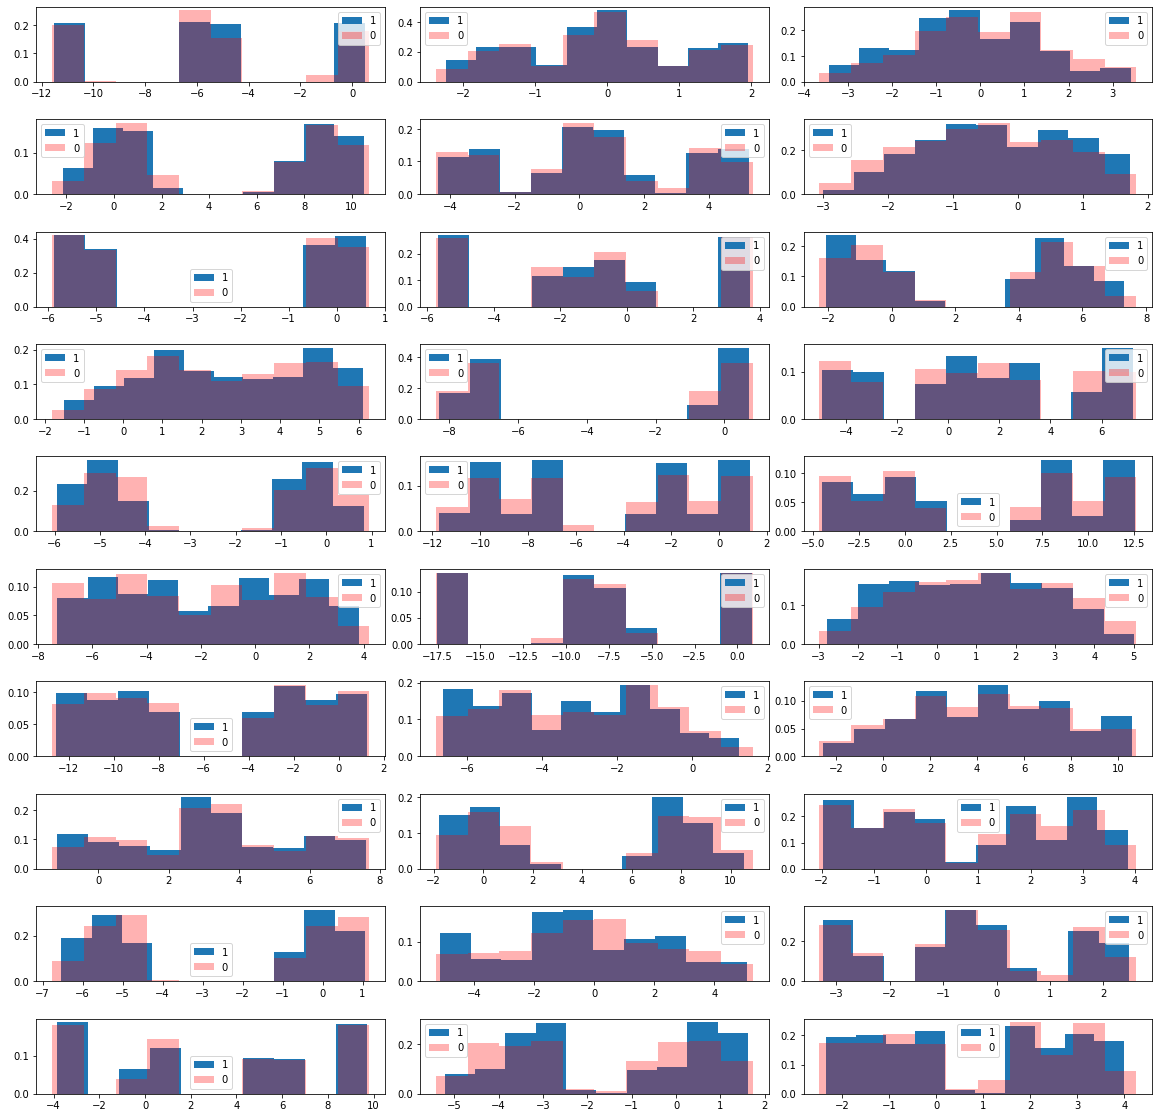

In [13]:
plt.figure(figsize=(20, 20))
for i, col in enumerate(train_features):
    plt.subplot(10, 3, i + 1)
    train[train['T'] == 1][col].hist(density = True, label = '1')
    train[train['T'] == 0][col].hist(density = True, label = '0', alpha = 0.3, color = 'red')
    plt.grid()
    plt.subplots_adjust(wspace=0.1, hspace=0.5)
    plt.legend()

In [14]:
corr = train[train_features].corr()
corr.style.background_gradient(cmap='coolwarm')

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29
X0,1.000000,0.031145,-0.077040,-0.567319,-0.028054,0.476806,0.749121,0.121708,-0.571722,-0.726516,0.686877,-0.129737,0.683068,0.851400,-0.535761,0.297342,0.996579,-0.485010,0.898878,0.859874,-0.842497,-0.963378,-0.714598,-0.318120,0.743160,-0.091972,0.223807,-0.464218,0.691441,-0.479282
X1,0.031145,1.000000,0.863083,-0.721880,-0.892052,-0.597165,-0.626580,0.943645,-0.712910,-0.628317,0.725128,-0.929919,0.676762,0.535860,0.760573,0.869726,-0.021137,0.610689,-0.379989,-0.192835,-0.208292,0.044906,-0.668275,-0.951635,-0.515249,0.964084,-0.958805,0.822044,-0.641145,0.793068
X2,-0.077040,0.863083,1.000000,-0.517676,-0.757397,-0.724601,-0.578594,0.747404,-0.503048,-0.579016,0.521796,-0.815606,0.599914,0.324246,0.601667,0.576025,-0.112599,0.701544,-0.362002,-0.092814,-0.173001,0.169072,-0.393396,-0.782428,-0.389438,0.945159,-0.821171,0.707682,-0.734679,0.642854
X3,-0.567319,-0.721880,-0.517676,1.000000,0.829177,0.353262,0.074219,-0.865431,0.978015,0.761740,-0.957156,0.864840,-0.940720,-0.870691,-0.364349,-0.917850,-0.504447,-0.361534,-0.217140,-0.195250,0.781030,0.596085,0.941050,0.886627,0.102676,-0.638674,0.605541,-0.447136,0.127910,-0.412069
X4,-0.028054,-0.892052,-0.757397,0.829177,1.000000,0.768934,0.590580,-0.972775,0.821193,0.477090,-0.722943,0.986291,-0.721984,-0.505494,-0.786259,-0.894997,0.039806,-0.789145,0.324588,0.311167,0.398108,0.073225,0.667316,0.895923,0.586239,-0.876280,0.905233,-0.857324,0.639851,-0.797253
X5,0.476806,-0.597165,-0.724601,0.353262,0.768934,1.000000,0.767114,-0.638573,0.330555,0.010242,-0.168922,0.711008,-0.276521,0.099585,-0.784812,-0.432132,0.528019,-0.991675,0.623398,0.589344,0.019361,-0.392717,0.061398,0.474663,0.747299,-0.732282,0.736272,-0.846324,0.897931,-0.775673
X6,0.749121,-0.626580,-0.578594,0.074219,0.590580,0.767114,1.000000,-0.554380,0.052158,-0.170034,0.041377,0.525313,0.083317,0.296679,-0.945957,-0.388311,0.787830,-0.782322,0.952998,0.825365,-0.497297,-0.751619,-0.086681,0.381817,0.955238,-0.691066,0.810003,-0.919785,0.947451,-0.927420
X7,0.121708,0.943645,0.747404,-0.865431,-0.972775,-0.638573,-0.554380,1.000000,-0.841235,-0.596594,0.798627,-0.982124,0.755262,0.606989,0.762572,0.962545,0.053582,0.654127,-0.285718,-0.211505,-0.388015,-0.120625,-0.761518,-0.954955,-0.532625,0.897562,-0.921140,0.820533,-0.568067,0.795176
X8,-0.571722,-0.712910,-0.503048,0.978015,0.821193,0.330555,0.052158,-0.841235,1.000000,0.723373,-0.959197,0.852334,-0.939376,-0.879562,-0.343320,-0.884375,-0.517541,-0.361513,-0.242883,-0.168634,0.787836,0.609889,0.942180,0.882185,0.073880,-0.603764,0.592227,-0.435414,0.096527,-0.360584
X9,-0.726516,-0.628317,-0.579016,0.761740,0.477090,0.010242,-0.170034,-0.596594,0.723373,1.000000,-0.878005,0.608611,-0.881946,-0.888283,-0.002844,-0.652153,-0.698142,0.022563,-0.411506,-0.637176,0.670419,0.591990,0.834824,0.778287,-0.301785,-0.574062,0.392928,-0.102047,-0.065558,-0.100384


Слишком большие кореляции признаков, возможно они линейно зависимы

In [15]:
def check_linear_relationship(df, col, train_features):
  '''
  Проверяем является ли col линейной комбинацией признаков train_features.remove(col) 
  '''
  new_train_features = copy.copy(train_features)
  new_train_features.remove(col)
  model = LinearRegression()
  model.fit(df[new_train_features], df[col])
  predicts = model.predict(df[new_train_features])
  return ((predicts - df[col])**2).mean()

def get_linear_relationship(df, train_features):
  '''
  генерируем словарь RMSE между предсказаниями модели и инстинными значениями признаков
  '''
  d = {}
  for col in train_features:
    d[col] = check_linear_relationship(df, col, train_features)
  return d

In [16]:
get_linear_relationship(df, train_features)

{'X0': 4.75431896796811e-30,
 'X1': 9.089741390638264e-31,
 'X10': 1.0217477354057994e-29,
 'X11': 6.794426759925145e-30,
 'X12': 1.7456944199179246e-30,
 'X13': 1.0190377134159536e-29,
 'X14': 4.28373707664303e-30,
 'X15': 3.211517264595157e-30,
 'X16': 2.811974548746812e-29,
 'X17': 1.3411158185986816e-30,
 'X18': 7.096353594078041e-30,
 'X19': 9.02026080948159e-30,
 'X2': 6.232605886574777e-31,
 'X20': 1.0480996910197483e-29,
 'X21': 1.8149688465235422e-30,
 'X22': 1.3799931481708002e-29,
 'X23': 7.640369001836975e-30,
 'X24': 1.1989090410003772e-29,
 'X25': 3.726571844348738e-31,
 'X26': 3.99865650373304e-31,
 'X27': 7.637827790099925e-30,
 'X28': 4.9329197935130054e-30,
 'X29': 1.4997704795272704e-30,
 'X3': 1.0585420339290606e-29,
 'X4': 3.859832925649248e-30,
 'X5': 9.03072997747823e-31,
 'X6': 4.765820345967457e-30,
 'X7': 5.627419177700333e-31,
 'X8': 2.1260340416253304e-30,
 'X9': 3.48184584153978e-30}

Каждый из признаков является линейной комбинацией остальных. Это ли "пасхалочка"?

In [17]:
def get_non_linear_relationship_features (df, train_features):
  '''
  выбираем линейно независимые признаки
  '''
  idx = 0
  non_linear_features = copy.copy(train_features)
  while idx < len(non_linear_features):
    col = non_linear_features[idx]
    if check_linear_relationship(df, col, non_linear_features) > 10**-5:
      idx += 1
    else:
      del non_linear_features[idx]
  return non_linear_features

In [18]:
non_linear_features = get_non_linear_relationship_features (df, train_features)

In [19]:
non_linear_features

['X25', 'X26', 'X27', 'X28', 'X29']

In [20]:
cv = StratifiedKFold()

In [21]:
model = CatBoostClassifier(iterations = 500, max_depth = 5, verbose=False)

Поскольку в данных большой дисбаланс, будем смотреть на метрики f1_score, roc auc. Какую именно выбрать, зависит от конкретной задачи

In [22]:
%%time
# обучаемся на линейно независимых признаках
cross_val_score(model, train[non_linear_features], train['T'], scoring = 'f1', cv = cv)

CPU times: user 2min 47s, sys: 12.5 s, total: 3min
Wall time: 1min 32s


array([0.80470002, 0.81674288, 0.8266433 , 0.82170543, 0.81552028])

In [24]:
%%time
# обучаемся на всех признаках
cross_val_score(model, train[train_features], train['T'], scoring = 'f1', cv = cv)

CPU times: user 3min 37s, sys: 12.2 s, total: 3min 50s
Wall time: 1min 58s


array([0.99152799, 0.98969697, 0.9897281 , 0.98939715, 0.98910412])

При обучении на всех признаках качество модели получается лучше. Видимо взаимодействие исходных линейно независимых признаков друг с другом добавляют информацию, позволяющую модели лучше разделить объекты

In [25]:
%%time
model.fit(train[train_features], train['T'])

CPU times: user 52.8 s, sys: 2.9 s, total: 55.7 s
Wall time: 28.6 s


In [29]:
roc_auc = roc_auc_score(test['T'].astype(int), model.predict_proba(test[train_features])[:,1])
print(f'roc auc score: {roc_auc}')

roc auc score: 0.999838562819112


In [32]:
f1 = f1_score(test['T'].astype(int), model.predict(test[train_features]))
print(f'f1 score: {f1}')

f1 score: 0.9951195999276978


# 2

In [33]:
df = pd.read_csv(os.path.join(DATA_DIR, 'tds.tsv'), sep = '\t', decimal=',', index_col = None)

In [34]:
df.head()

,D0,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31,D32,D33,D34,D35,D36,D37,D38,D39,D40,D41,D42,D43,D44,D45,D46,D47,D48,D49,D50,D51,D52,D53,RES
0,0.555913,-0.219430,1.716566,-1.476293,0.735564,0.962259,-0.806617,1.717255,-0.948386,0.359442,0.192133,0.707526,0.076579,-0.018483,-1.601854,1.176536,0.351055,0.966962,-0.612530,-0.253700,-1.571074,0.736592,1.446911,0.184530,0.119860,-1.724884,1.267585,0.791957,1.342465,0.027266,-0.397835,-1.267517,0.260122,1.822030,1.109418,-1.026176,0.734792,-0.213339,0.774385,-1.092603,-0.159108,-0.916304,-0.066097,1.660392,-0.678083,-1.075021,0.639739,-1.189910,1.916465,1.409899,0.407483,0.757498,-5.399183,3.151085,-22.083431
1,0.275801,0.720971,-0.021266,-0.834974,0.621100,0.228773,-0.726037,0.513192,0.175872,-0.049454,-0.115371,0.496140,0.082360,-1.037452,-0.199331,-0.113366,-0.198285,0.740788,-0.435492,-0.419082,-0.939249,-0.179989,0.471888,0.417904,0.869206,0.221551,0.670068,0.373177,-0.017873,-0.396951,-0.482850,0.583749,0.233245,0.812427,-0.411379,-0.341610,0.609881,-0.527539,-0.622399,-1.482904,-0.136467,-0.223401,-0.006264,0.202777,-0.421734,0.241560,0.625477,0.696503,-0.064844,-0.186206,-0.477025,0.099725,-1.063445,1.717277,3.450500
2,0.167323,0.353376,1.058144,-0.600743,-0.127594,-0.689665,-0.373672,-0.117344,0.162418,0.283151,-0.470599,0.165407,-0.312826,-0.412652,-0.180359,0.305851,0.226061,0.098168,0.488151,0.087813,-0.291674,0.182124,0.594883,0.583324,0.305868,-0.350606,0.688350,-0.100798,-0.451411,0.148214,-0.644213,0.056662,-0.481239,0.675289,0.314538,-0.128308,-0.097709,-0.479818,0.072454,-0.916132,0.686268,-0.912122,0.197235,0.799298,-0.755004,-0.277547,0.821749,0.234148,1.887915,-0.678010,-0.929504,-0.948924,-2.521030,1.472775,-3.366255
3,-0.691238,0.289088,-1.995313,0.859964,-0.039270,-0.347356,1.072668,-0.407652,0.446329,-1.298777,1.668952,0.015494,-0.508657,-0.366138,0.393014,-0.403645,0.601145,-0.993204,1.215208,0.226738,0.701666,-0.913812,-1.794707,0.135408,0.198102,0.462991,-0.385292,1.089831,0.139076,0.179812,-0.586072,0.193834,-0.029190,-1.160818,-1.071999,1.883474,1.007346,-0.064577,0.408420,1.765827,1.309576,0.413722,-0.008640,-1.106868,0.927737,0.407405,-1.344360,-1.098631,0.804352,-0.150594,-2.326416,-0.167717,4.115947,-0.846033,7.456708
4,-1.059742,-0.101273,0.056621,0.834727,0.800732,0.247648,0.429963,-1.180303,0.366667,-0.158897,0.196511,-0.212925,0.410241,-0.768982,0.652134,0.502432,0.047803,-0.079762,-0.826833,0.073274,0.326240,-0.641265,-0.950814,-0.194084,-0.321615,1.029998,-0.065206,0.777249,1.083681,-0.334571,-1.205444,-0.063117,-0.405400,-0.702534,0.913330,-0.683570,0.549006,0.261405,-0.402480,0.440701,0.481888,1.315462,-0.082819,-0.185129,0.382740,0.206111,-1.268718,-1.508868,0.529242,1.279921,-1.737435,0.450484,-1.173966,-1.227253,2.857195


In [37]:
df.shape

(50000, 55)

In [35]:
train, test = train_test_split(df, test_size = 0.3, shuffle = True)

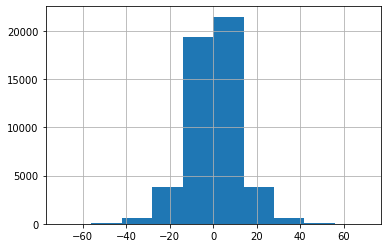

In [36]:
df['RES'].hist()

In [38]:
train_features = list(df.columns.drop('RES'))

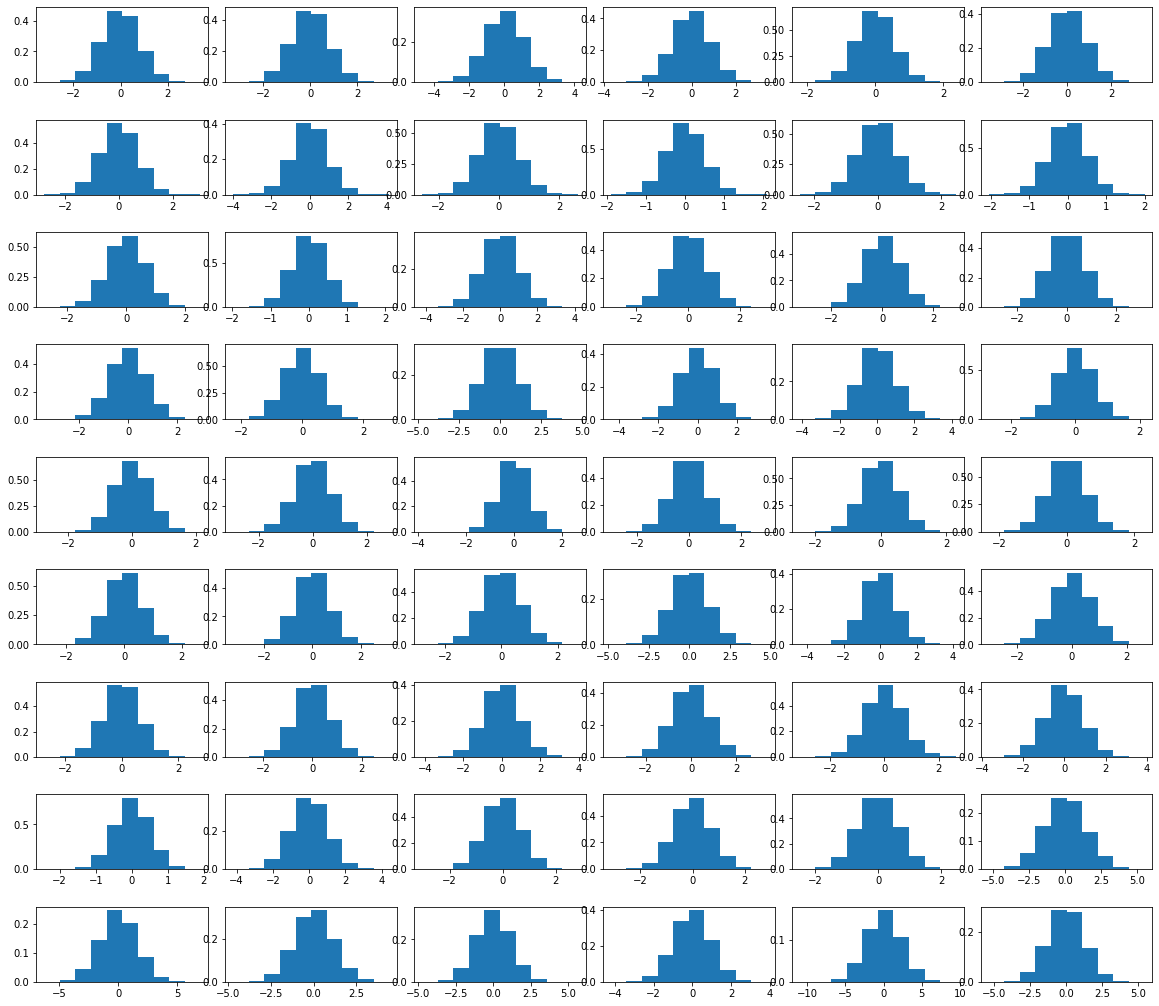

In [39]:
plt.figure(figsize=(20, 20))
for i, col in enumerate(train_features):
    plt.subplot(10, 6, i + 1)
    train[col].hist(density = True)
    plt.grid()
    plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [40]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

In [43]:
def get_score(model, df, features):
  '''
  расчет качества по формуле из файла
  '''
  mean = df['RES'].mean()
  rmse_model = mean_squared_error(test['RES'], model.predict(test[features]))
  rmse_mse = mean_squared_error(test['RES'], [mean for _ in range(len(test))])
  return 1 - (rmse_model/rmse_mse)

Отберем признаки при помощи Lasso регрессии, затем посмотрим как будет изменяться качество модели при добавлении признаков в порядке важности (сначала - самые важные)

In [96]:
model = Lasso(alpha = 0.1)

In [97]:
model.fit(train[train_features], train['RES'])

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [98]:
idx_features = np.argsort(abs(model.coef_))[::-1]

In [99]:
scores = []
train_features = np.array(train_features)
for idx in range(len(idx_features)):
  model = LinearRegression()
  model.fit(train[train_features[idx_features[:idx + 1]]], train['RES'])
  score = get_score(model, test, train_features[idx_features[:idx + 1]])
  scores.append(score)

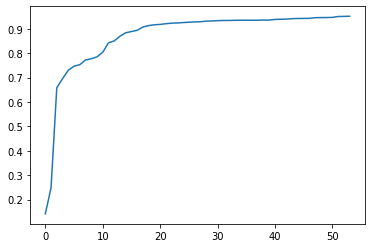

In [100]:
plt.plot(scores)

In [101]:
important_features = train_features[idx_features[:18]]

In [102]:
important_features

array(['D19', 'D38', 'D22', 'D15', 'D9', 'D2', 'D27', 'D8', 'D5', 'D43',
       'D31', 'D44', 'D34', 'D46', 'D0', 'D21', 'D24', 'D39'], dtype='<U3')

In [107]:
model = LinearRegression()
model.fit(train[important_features], train['RES'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [108]:
get_score(model, test, important_features)

0.9073429425855163

In [111]:
scores[-1]

0.9516425030379589

Можно оставить 18 признаков и получить 0.907 качества, остальные 36 признаков добавляют только 0.04 качества